In [1]:
import dask
from dask.distributed import Client
import dask.dataframe as dd
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from scipy import sparse

In [2]:
import matplotlib.pyplot as plt 

# Benign vs. Malware EDA

In [3]:
benignfp = "../data/tests/interim/b_features/*csv"
malwarefp = "../data/tests/interim/m_features/*csv"

In [4]:
client = Client(n_workers = 8)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:60361 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 68.72 GB


In [6]:
benign = dd.read_csv(benignfp)

malware = dd.read_csv(malwarefp)

In [7]:
display(benign.head())
display(malware.head())

,api,invocation,block,app,malware
0,Ljava/lang/Object;-><init>,invoke-direct,public constructor <init>()VBuildConfig.smali,%D8%A7%D8%B3%D8%AA%D8%B1%D8%AC%D8%A7%D8%B9-%D9...,0
1,Landroid/support/v4/accessibilityservice/Acces...,invoke-direct,constructor <init>()VAccessibilityServiceInfoC...,%D8%A7%D8%B3%D8%AA%D8%B1%D8%AC%D8%A7%D8%B9-%D9...,0
2,Landroid/support/v4/accessibilityservice/Acces...,invoke-static,public getCanRetrieveWindowContent(Landroid/ac...,%D8%A7%D8%B3%D8%AA%D8%B1%D8%AC%D8%A7%D8%B9-%D9...,0
3,Landroid/support/v4/accessibilityservice/Acces...,invoke-virtual,public getCapabilities(Landroid/accessibilitys...,%D8%A7%D8%B3%D8%AA%D8%B1%D8%AC%D8%A7%D8%B9-%D9...,0
4,Landroid/support/v4/accessibilityservice/Acces...,invoke-static,public getDescription(Landroid/accessibilityse...,%D8%A7%D8%B3%D8%AA%D8%B1%D8%AC%D8%A7%D8%B9-%D9...,0


,api,invocation,block,app,malware
0,Ljava/lang/Object;-><init>,invoke-direct,public constructor <init>()VR$attr.smali,00d41cb8eabffec00272b0a4574cd6c9,1
1,Ljava/lang/Object;-><init>,invoke-direct,public constructor <init>()VR$color.smali,00d41cb8eabffec00272b0a4574cd6c9,1
2,Ljava/lang/Object;-><init>,invoke-direct,public constructor <init>()VR$drawable.smali,00d41cb8eabffec00272b0a4574cd6c9,1
3,Ljava/lang/Object;-><init>,invoke-direct,public constructor <init>()VR$id.smali,00d41cb8eabffec00272b0a4574cd6c9,1
4,Ljava/lang/Object;-><init>,invoke-direct,public constructor <init>()VR$layout.smali,00d41cb8eabffec00272b0a4574cd6c9,1


## API Calls

### how many rows benign apps have

In [8]:
len(benign)

2592189

### how many rows malware apps have

In [9]:
len(malware)

154020

### how many benign sample we collected

In [10]:
len(benign.app.unique())

33

### how many malware samples we collected

In [11]:
len(malware.app.unique())

20

### TOP 20 normalized API call comparison 

In [12]:
apical_v = benign.api.value_counts().compute()
apical_v_m = malware.api.value_counts().compute()

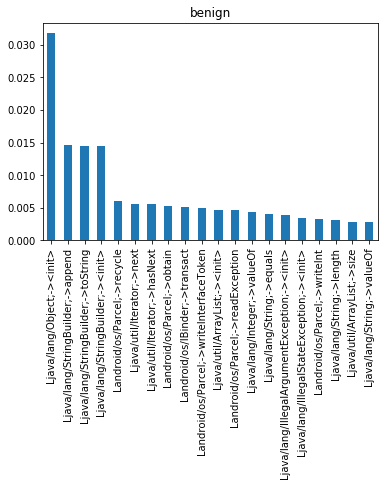

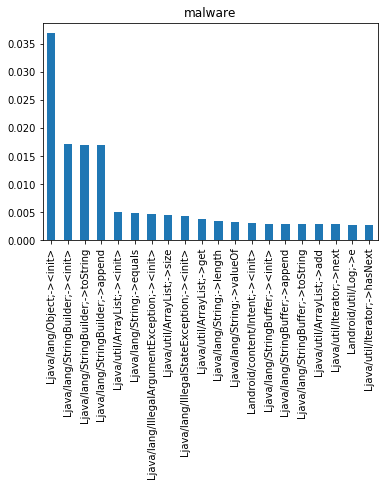

In [13]:
plt.show((apical_v / apical_v.sum()).head(20).plot.bar(title = "benign"))
plt.show((apical_v_m / apical_v_m.sum()).head(20).plot.bar(title = "malware"))

### TOP 100 api calls (percentage in common)

In [14]:
apical_v.head(100).isin(apical_v_m.head(100)).mean()

0.0

### Observation
Following finding from eda above:
  - In general, Benign apps are much more complicated than malware apps in structures. we collected 89 benign apps and 63 malware apps, but there are 6190118 rows of infomation for benign apps and 39345 rows of information for malware apps.
  - As plot shown above, the proportion (distribution) of Malware and Benign's api calls are relatively same.
  - The most common api calls are significantly different. For top 100 api calls of benign apps and malware apps, there are no common api calls.

## Number of abnormal Apis

to find the cut between normal api and abnormal api

In [24]:
bgrouped = benign.groupby('api').size().compute()
mgrouped = malware.groupby('api').size().compute()

In [26]:
bgrouped.describe()

count    298185.000000
mean          8.693224
std         221.244689
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max       82483.000000
dtype: float64

In [27]:
mgrouped.describe()

count    23830.000000
mean         6.463282
std         51.278840
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       5687.000000
dtype: float64

## invocation

In [46]:
binvo = benign.invocation.value_counts().compute()
minvo = malware.invocation.value_counts().compute()

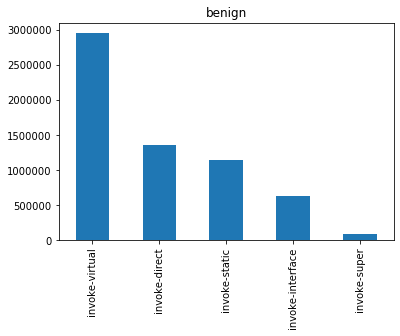

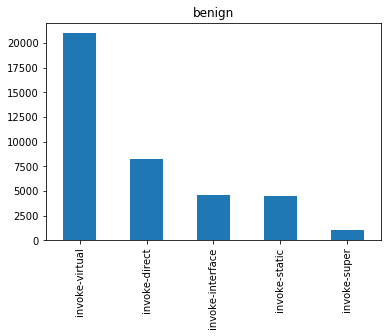

In [49]:
plt.show(binvo.plot.bar(title = 'benign'))
plt.show(minvo.plot.bar(title = 'benign'))

### Observation
Following finding from eda above:
  - In general, the distribution of invocation between benign apps and malware apps are roughly same: with invoke-virtual the most commonly used, and invok-super the least commonly used in both.
  - There is one abnormal scene found: in benign apps, invoke-static is the third commonly used, and invoke-interface is the fourth commonly used. But in malware apps, invoke-interface is the third commonly used, and invoke-static is the fourth commonly used. To ensure the abnormality, we should fetch more data.